## Importing the Libraries

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Importing the dataset

In [239]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')


## Cleaning the dataset

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [241]:
df = df.drop(['Date', 'Location', 'WindDir9am',
             'WindGustDir', 'WindDir3pm'], axis=1)
df = df.dropna(how='any')
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58090 entries, 6049 to 142302
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        58090 non-null  float64
 1   MaxTemp        58090 non-null  float64
 2   Rainfall       58090 non-null  float64
 3   Evaporation    58090 non-null  float64
 4   Sunshine       58090 non-null  float64
 5   WindGustSpeed  58090 non-null  float64
 6   WindSpeed9am   58090 non-null  float64
 7   WindSpeed3pm   58090 non-null  float64
 8   Humidity9am    58090 non-null  float64
 9   Humidity3pm    58090 non-null  float64
 10  Pressure9am    58090 non-null  float64
 11  Pressure3pm    58090 non-null  float64
 12  Cloud9am       58090 non-null  float64
 13  Cloud3pm       58090 non-null  float64
 14  Temp9am        58090 non-null  float64
 15  Temp3pm        58090 non-null  float64
 16  RainToday      58090 non-null  object 
 17  RainTomorrow   58090 non-null  object 
dtypes: floa

In [243]:
y = df['RainTomorrow']
X = df.drop('RainTomorrow', axis=1)

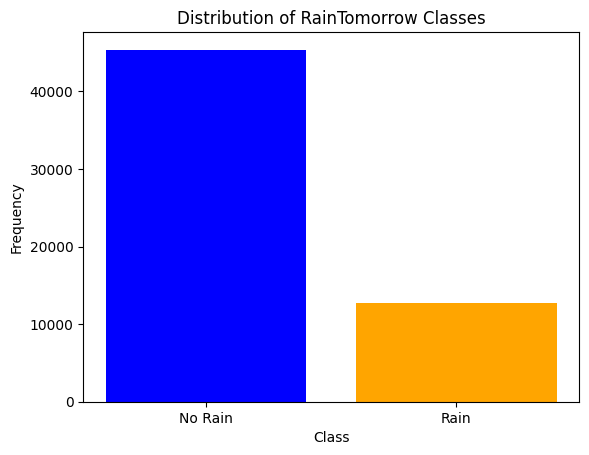

In [244]:
# Count the occurrences of each class
unique, counts = np.unique(y, return_counts=True)

# Create the bar plot
plt.bar(unique, counts, color=['blue', 'orange'])

# Add labels and title
plt.xticks([0, 1], ['No Rain', 'Rain'])  # Rename the x-axis tick labels if needed
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of RainTomorrow Classes')

# Show the plot
plt.show()


In [245]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)

In [246]:
le = LabelEncoder()
y = le.fit_transform(y.values.ravel())


## Creating the Model

In [247]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, emb_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(input_size, 16),
        nn.ReLU(),
        nn.Linear(16, emb_dim),
        nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
        nn.Linear(emb_dim, 16),
        nn.ReLU(),
        nn.Linear(16, input_size),
        nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [248]:
input_size = X_scaled.shape[1]
emb_dim = 5
model = Autoencoder(input_size=input_size, emb_dim=emb_dim)

## Difining optimizer and criterion

In [249]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the Model

In [250]:
Epochs = 800
Losses = {}

for epoch in range(Epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()
    Losses[epoch] = loss.item()
    

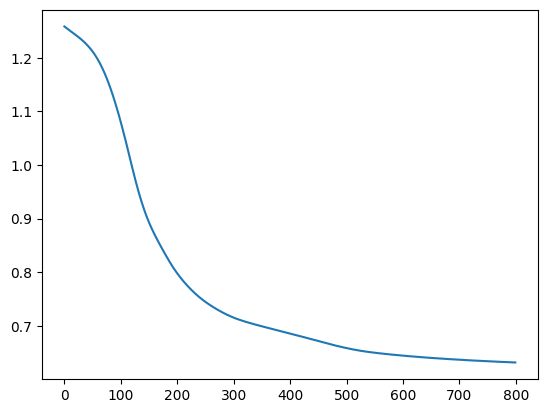

In [251]:
plt.plot(Losses.values())

## Extract the encoded features using the encoder

In [252]:
with torch.no_grad():  # Disable gradient tracking
    encoded_features = model.encoder(X_tensor).numpy()

## Split the data

In [253]:
X_train, X_test, y_train, y_test = train_test_split(encoded_features, y, test_size=0.2, random_state=123, stratify=y)

# Train XGBoost


In [254]:
class_weights = {0: len(y_train) / (2 * np.bincount(y_train)[0]), 
                 1: len(y_train) / (2 * np.bincount(y_train)[1])}

# Initialize XGBoost with scale_pos_weight for imbalanced data
xgb_model = XGBClassifier(scale_pos_weight=class_weights[1] / class_weights[0])
xgb_model.fit(X_train, y_train)
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the accuracy

In [255]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 78.62%
Precision: 0.51
Recall: 0.77
F1 Score: 0.61
